In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [1]:
! pip install pydicom

     |████████████████████████████████| 7.1MB 2.7MB/s 


In [3]:
import numpy as np
import pandas as pd
import pydicom
import os
from os import listdir

from os.path import isfile, join
import matplotlib.pyplot as plt
import collections
from tqdm import tqdm_notebook as tqdm
from datetime import datetime

from math import ceil, floor, log
import cv2

import tensorflow as tf
import keras

import sys

# from keras_applications.resnet import ResNet50
from keras_applications.inception_v3 import InceptionV3

from sklearn.model_selection import ShuffleSplit
test_images_dir = '/content/drive/My Drive/Sample of Sampled Data/Test_Sample/'
train_images_dir = '/content/drive/My Drive/Sample of Sampled Data/'

Using TensorFlow backend.


In [0]:
def read_testset(filename="/content/drive/My Drive/Sample of Sampled Data/CSV Files/test_sample.csv"):
    df = pd.read_csv(filename)

    
    df = df.loc[:, ["Label", "Type", "ID_Image"]]
    df = df.set_index(['ID_Image', 'Type']).unstack(level=-1)
    
    return df

def read_trainset(filename="/content/drive/My Drive/Sample of Sampled Data/CSV Files/train_sample.csv"):
    df = pd.read_csv(filename)

    
    
    df = df.loc[:, ["Label", "Type", "ID_Image"]]
    df = df.set_index(['ID_Image', 'Type']).unstack(level=-1)
    
    return df

train_df = read_trainset()   
test_df = read_testset()

In [0]:
train_df.columns = train_df.columns.get_level_values(1)
test_df.columns = test_df.columns.get_level_values(1)

In [0]:
train_df.reset_index(inplace=True)
test_df.reset_index(inplace=True)

In [0]:
# train_df.head(10)

In [0]:
# # Images Example
# train_images = [f for f in listdir(train_images_dir) if isfile(join(train_images_dir, f))]
# test_images = [f for f in listdir(test_images_dir) if isfile(join(test_images_dir, f))]
# print('5 Training images', train_images[:5]) # Print the first 5

In [0]:
# train_images = [f for f in listdir(train_images_dir) if isfile(join(train_images_dir, f))]
# test_images = [f for f in listdir(test_images_dir) if isfile(join(test_images_dir, f))]

In [0]:
# for i in train_images[:1]:
#   dicom = pydicom.dcmread(train_images_dir + i)
#   print(dicom.pixel_array) 
#   print(dicom.pixel_array.shape)

In [0]:
def view_images(images):
    #width = 5
    #height = 2
    #fig, axs = plt.subplots(height, width, figsize=(15,5))
    figsize=(15,5)
    
    image = images
    i = im // width
    j = im % width
    axs[i,j].imshow(image, cmap=plt.cm.bone) 
    axs[i,j].axis('off')
    title = hem_types[im] if im < len(hem_types) else 'normal'
    axs[i,j].set_title(title)

    plt.show()

In [0]:
def correct_dcm(dcm):
    x = dcm.pixel_array + 1000
    px_mode = 4096
    x[x>=px_mode] = x[x>=px_mode] - px_mode
    dcm.PixelData = x.tobytes()
    dcm.RescaleIntercept = -1000

def window_image(dcm, window_center, window_width):
    
    if (dcm.BitsStored == 12) and (dcm.PixelRepresentation == 0) and (int(dcm.RescaleIntercept) > -100):
        correct_dcm(dcm)
    
    img = dcm.pixel_array * dcm.RescaleSlope + dcm.RescaleIntercept
    img_min = window_center - window_width // 2
    img_max = window_center + window_width // 2
    img = np.clip(img, img_min, img_max)

    return img

def bsb_window(dcm):
    brain_img = window_image(dcm, 40, 80)
    plt.plot(brain_img)
    subdural_img = window_image(dcm, 80, 200)
    plt.plot(subdural_img)
    soft_img = window_image(dcm, 40, 380)
    plt.plot(soft_img)
    
    brain_img = (brain_img - 0) / 80
    subdural_img = (subdural_img - (-20)) / 200
    soft_img = (soft_img - (-150)) / 380
    bsb_img = np.array([brain_img, subdural_img, soft_img]).transpose(1,2,0)

    return bsb_img

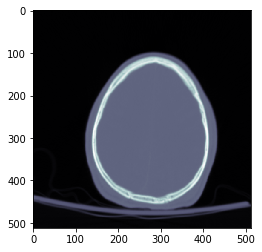

In [26]:
dcm = pydicom.dcmread(train_images_dir+train_images[2])
plt.imshow(dcm.pixel_array, cmap=plt.cm.bone)
plt.savefig('1.png')

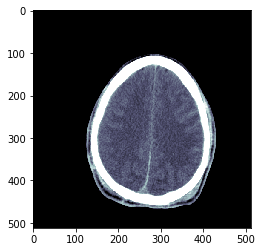

In [31]:
dcm = pydicom.dcmread(train_images_dir+train_images[2])
#view_images(bsb_window(dcm))
#bsb_window(dcm)
brain_img = window_image(dcm, 40, 80)
plt.imshow(brain_img, cmap=plt.cm.bone)
#plt.savefig('brain.png')

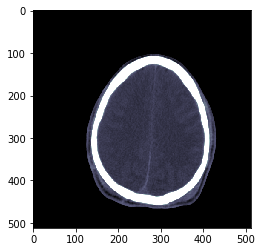

In [28]:
subdural_img = window_image(dcm, 80, 200)
plt.imshow(subdural_img, cmap=plt.cm.bone)
plt.savefig('subdural.png')

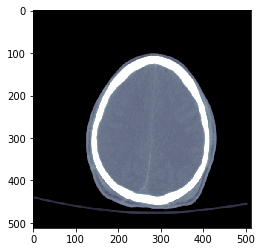

In [29]:
soft_img = window_image(dcm, 40, 380)
plt.imshow(soft_img, cmap=plt.cm.bone)
plt.savefig('soft.png')

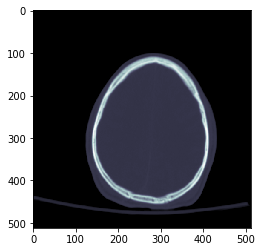

In [24]:
bone_img = window_image(dcm, 600, 2000)
plt.imshow(bone_img, cmap=plt.cm.bone)

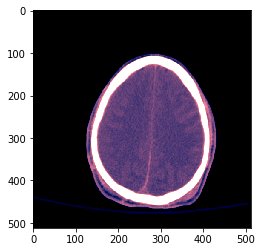

In [36]:
brain_img = window_image(dcm, 40, 80)
subdural_img = window_image(dcm, 80, 200)
soft_img = window_image(dcm, 40, 380)

brain_img = (brain_img - 0) / 80
subdural_img = (subdural_img - (-20)) / 200
soft_img = (soft_img - (-150)) / 380
bsb_img = np.array([brain_img, subdural_img, soft_img]).transpose(1,2,0)
plt.imshow(bsb_img, cmap=plt.cm.bone)
plt.savefig('three_layer.png')

In [0]:
# non = train_df[train_df['any'] == 0]['ID_Image'].iloc[1]
# epidural = train_df[train_df['epidural'] == 1]['ID_Image'].iloc[1]
# intraparenchymal = train_df[train_df['intraparenchymal'] == 1]['ID_Image'].iloc[1]
# intraventricular = train_df[train_df['intraventricular'] == 1]['ID_Image'].iloc[1]
# subarachnoid = train_df[train_df['subarachnoid'] == 1]['ID_Image'].iloc[1]
# subdural = train_df[train_df['subdural'] == 1]['ID_Image'].iloc[1]

# # example of a "bad data point" (i.e. (dcm.BitsStored == 12) and (dcm.PixelRepresentation == 0) and (int(dcm.RescaleIntercept) > -100) == True)
# dicom_non = pydicom.dcmread(train_images_dir + non + ".dcm")
# dicom_epidural = pydicom.dcmread(train_images_dir + epidural + ".dcm")
# dicom_intraparenchymal = pydicom.dcmread(train_images_dir + intraparenchymal + ".dcm")
# dicom_intraventricular = pydicom.dcmread(train_images_dir + intraventricular + ".dcm")
# dicom_subarachnoid = pydicom.dcmread(train_images_dir + subarachnoid + ".dcm")
# dicom_subdural = pydicom.dcmread(train_images_dir + subdural + ".dcm")

In [0]:
# for i in [dicom_non, dicom_epidural, dicom_intraparenchymal, dicom_intraventricular, dicom_subarachnoid, dicom_subdural]:
#   brain_img = window_image(i, 40, 80)
#   subdural_img = window_image(i, 80, 200)
#   soft_img = window_image(i, 40, 380)
#   brain_img_1 = (brain_img - 0) / 80
#   subdural_img_1 = (subdural_img - (-20)) / 200
#   soft_img_1 = (soft_img - (-150)) / 380
#   bsb_img = np.array([brain_img, subdural_img, soft_img]).transpose(1,2,0)
#   plt.imshow(bsb_img, cmap=plt.cm.bone)

In [0]:
def _read(path, desired_size):
    """Will be used in DataGenerator"""
    
    dcm = pydicom.dcmread(path)
    
    try:
        img = bsb_window(dcm)
    except:
        img = np.zeros(desired_size)
    
    
    img = cv2.resize(img, desired_size[:2], interpolation=cv2.INTER_LINEAR)
    
    return img

In [0]:
#_read(train_images_dir+'ID_5c8b5d701'+'.dcm', (128, 128))

In [0]:
train_images = [f for f in listdir(train_images_dir) if isfile(join(train_images_dir, f))]
test_images = [f for f in listdir(test_images_dir) if isfile(join(test_images_dir, f))]

In [0]:
train_images_ID = [s.strip('.dcm') for s in train_images]
test_images_ID = [s.strip('.dcm') for s in test_images]

In [0]:
p_train = []
a = 0
for i in train_images:
  a += 1
  print(a)
  dicom = _read(train_images_dir+i, (128, 128)) 
  p_train.append(dicom)
a = 0
p_test = []
for i in test_images:
  a += 1
  print(a)
  dicom = _read(test_images_dir+i, (128, 128)) 
  p_test.append(dicom)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [0]:
# len(p_test)

In [0]:
# len(test_images_ID)

In [0]:
l_train =  list(zip(train_images_ID, p_train))
train_pixel = pd.DataFrame(l_train, columns = ['ID_Image' , 'pixel']) 
l_test =  list(zip(test_images_ID, p_test))
test_pixel = pd.DataFrame(l_test, columns = ['ID_Image' , 'pixel']) 

In [0]:
train_merge = train_df.merge(train_pixel, left_on='ID_Image', right_on='ID_Image', how='inner')
test_merge = test_df.merge(test_pixel, left_on='ID_Image', right_on='ID_Image', how='inner')

In [0]:
test_merge.columns

Index(['ID_Image', 'any', 'epidural', 'intraparenchymal', 'intraventricular',
       'subarachnoid', 'subdural', 'pixel'],
      dtype='object')

In [0]:
train_X = train_merge.drop(columns = ['ID_Image','any', 'epidural', 'intraparenchymal', 'intraventricular', 'subarachnoid', 'subdural'])
train_X = np.stack(train_X['pixel'].tolist(),axis=0)
train_Y = np.array(train_merge[['any', 'epidural', 'intraparenchymal', 'intraventricular', 'subarachnoid', 'subdural']])
test_X = test_merge.drop(columns = ['ID_Image','any', 'epidural', 'intraparenchymal', 'intraventricular', 'subarachnoid', 'subdural'])
test_X = np.stack(test_X['pixel'].tolist(),axis=0)
test_Y = np.array(test_merge[['any', 'epidural', 'intraparenchymal', 'intraventricular', 'subarachnoid', 'subdural']])


In [0]:
print('Training Set X Shape:', train_X.shape)
print('Training Set Y Shape:', train_Y.shape)
print('Testing Set X Shape:', test_X.shape)
print('Testing Set Y Shape:', test_Y.shape)

Training Set X Shape: (6382, 128, 128, 3)
Training Set Y Shape: (6382, 6)
Testing Set X Shape: (1102, 128, 128, 3)
Testing Set Y Shape: (1102, 6)


In [0]:
import keras
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16, preprocess_input

In [0]:
from keras import backend as K

def weighted_log_loss(y_true, y_pred):
    """
    Can be used as the loss function in model.compile()
    ---------------------------------------------------
    """
    
    class_weights = np.array([2., 1., 1., 1., 1., 1.])
    
    eps = K.epsilon()
    
    y_pred = K.clip(y_pred, eps, 1.0-eps)

    out = -(         y_true  * K.log(      y_pred) * class_weights
            + (1.0 - y_true) * K.log(1.0 - y_pred) * class_weights)
    
    return K.mean(out, axis=-1)
def _normalized_weighted_average(arr, weights=None):
    """
    A simple Keras implementation that mimics that of 
    numpy.average(), specifically for this competition
    """
    
    if weights is not None:
        scl = K.sum(weights)
        weights = K.expand_dims(weights, axis=1)
        return K.sum(K.dot(arr, weights), axis=1) / scl
    return K.mean(arr, axis=1)

def weighted_loss(y_true, y_pred):
    """
    Will be used as the metric in model.compile()
    ---------------------------------------------
    
    Similar to the custom loss function 'weighted_log_loss()' above
    but with normalized weights, which should be very similar 
    to the official competition metric:
        https://www.kaggle.com/kambarakun/lb-probe-weights-n-of-positives-scoring
    and hence:
        sklearn.metrics.log_loss with sample weights
    """
    
    class_weights = K.variable([2., 1., 1., 1., 1., 1.])
    
    eps = K.epsilon()
    
    y_pred = K.clip(y_pred, eps, 1.0-eps)

    loss = -(        y_true  * K.log(      y_pred)
            + (1.0 - y_true) * K.log(1.0 - y_pred))
    
    loss_samples = _normalized_weighted_average(loss, class_weights)
    
    return K.mean(loss_samples)

def weighted_log_loss_metric(trues, preds):
    """
    Will be used to calculate the log loss 
    of the validation set in PredictionCheckpoint()
    ------------------------------------------
    """
    class_weights = [2., 1., 1., 1., 1., 1.]
    
    epsilon = 1e-7
    
    preds = np.clip(preds, epsilon, 1-epsilon)
    loss = trues * np.log(preds) + (1 - trues) * np.log(1 - preds)
    loss_samples = np.average(loss, axis=1, weights=class_weights)

    return - loss_samples.mean()

In [0]:
cnn_model = Sequential()
# Convolutional Layer 1:
cnn_model.add(Conv2D(32, kernel_size = (3, 3), activation = 'linear', input_shape = (128, 128, 3), padding = 'same'))
cnn_model.add(LeakyReLU(alpha = 0.1))
# Max Pooling Layer 1:
cnn_model.add(MaxPooling2D((2, 2),padding = 'same'))
# Convolutional Layer 2:
cnn_model.add(Conv2D(64, kernel_size = (3, 3), activation = 'linear', padding = 'same'))
cnn_model.add(LeakyReLU(alpha = 0.1))
# Max Pooling Layer 2:
cnn_model.add(MaxPooling2D((2, 2),padding = 'same'))
# Convolutional Layer 3:
cnn_model.add(Conv2D(128, kernel_size = (3, 3), activation = 'linear', padding = 'same'))
cnn_model.add(LeakyReLU(alpha = 0.1))
# Max Pooling Layer 3:
cnn_model.add(MaxPooling2D((2, 2),padding = 'same'))
# Flatten Preprocessing:
cnn_model.add(Flatten())
# Fully Connected Layer (Dense Layer):
cnn_model.add(Dense(128, activation = 'linear'))
cnn_model.add(LeakyReLU(alpha = 0.1))
# Output Layer (Dense Layer):
cnn_model.add(Dense(6, activation = 'sigmoid')) # choose one of them? # softmax

# Compile CNN model
cnn_model.compile(loss = "binary_crossentropy", optimizer = keras.optimizers.Adam(), metrics = [weighted_loss])
cnn_model.summary()







Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 128, 128, 32)      896       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 128, 128, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 64, 64, 64)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 64)        0         
____________________

In [0]:
datagen = ImageDataGenerator(
    rotation_range = 30,
    horizontal_flip = True)
datagen.fit(train_X)

# Fits the model on batches with real-time data augmentation:
cnn_model_process = cnn_model.fit_generator(datagen.flow(train_X, train_Y, batch_size = 32),
                                                            steps_per_epoch = len(train_X) / 32, 
                                                            epochs = 10, verbose = 1, validation_data = (test_X, test_Y))
# cnn_model_process = cnn_model.fit(train_X, train_Y, batch_size = 32, epochs = 20, verbose = 1, validation_data = (test_X, test_Y))




Epoch 1/10





200/199 [==============================] - 29s 145ms/step - loss: 0.3913 - weighted_loss: 0.4187 - val_loss: 0.3769 - val_weighted_loss: 0.4035
Epoch 2/10
200/199 [==============================] - 22s 112ms/step - loss: 0.3651 - weighted_loss: 0.3902 - val_loss: 0.3487 - val_weighted_loss: 0.3732
Epoch 3/10
200/199 [==============================] - 22s 112ms/step - loss: 0.3546 - weighted_loss: 0.3784 - val_loss: 0.3387 - val_weighted_loss: 0.3612
Epoch 4/10
200/199 [==============================] - 22s 112ms/step - loss: 0.3434 - weighted_loss: 0.3659 - val_loss: 0.3402 - val_weighted_loss: 0.3606
Epoch 5/10
200/199 [==============================] - 22s 111ms/step - loss: 0.3267 - weighted_loss: 0.3463 - val_loss: 0.3677 - val_weighted_loss: 0.3976
Epoch 6/10
200/199 [==============================] - 22s 111ms/step - loss: 0.3183 - weighted_loss: 0.3377 - val_loss: 0.3235 - val_weighted_loss: 0.3449
Epoch 7/10
200/199 [==============================] - 23s 113m

In [0]:
# cnn_model_process.history

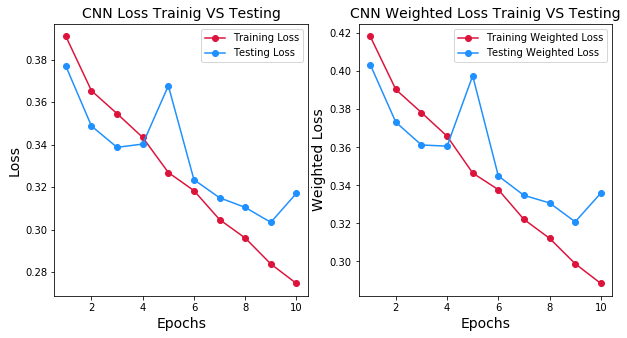

In [0]:
fig, axes = plt.subplots(1, 2, figsize = (10, 5))
axes[0].plot(range(1, len(cnn_model_process.history['loss']) + 1), cnn_model_process.history['loss'], linestyle = 'solid', marker = 'o', color = 'crimson', label = 'Training Loss')
axes[0].plot(range(1, len(cnn_model_process.history['val_loss']) + 1), cnn_model_process.history['val_loss'], linestyle = 'solid', marker = 'o', color = 'dodgerblue', label = 'Testing Loss')
axes[0].set_xlabel('Epochs', fontsize = 14)
axes[0].set_ylabel('Loss',fontsize = 14)
axes[0].set_title('CNN Loss Trainig VS Testing', fontsize = 14)
axes[0].legend(loc = 'best')
axes[1].plot(range(1, len(cnn_model_process.history['weighted_loss']) + 1), cnn_model_process.history['weighted_loss'], linestyle = 'solid', marker = 'o', color = 'crimson', label = 'Training Weighted Loss')
axes[1].plot(range(1, len(cnn_model_process.history['val_weighted_loss']) + 1), cnn_model_process.history['val_weighted_loss'], linestyle = 'solid', marker = 'o', color = 'dodgerblue', label = 'Testing Weighted Loss')
axes[1].set_xlabel('Epochs', fontsize = 14)
axes[1].set_ylabel('Weighted Loss',fontsize = 14)
axes[1].set_title('CNN Weighted Loss Trainig VS Testing', fontsize = 14)
axes[1].legend(loc = 'best')

In [0]:

cnn_model_dropout = Sequential()
# Convolutional Layer 1:
cnn_model_dropout.add(Conv2D(32, kernel_size = (3, 3), activation = 'linear', input_shape = (128, 128, 3), padding = 'same'))
cnn_model_dropout.add(LeakyReLU(alpha = 0.1))
# Max Pooling Layer 1:
cnn_model_dropout.add(MaxPooling2D((2, 2),padding = 'same'))
# Convolutional Layer 2:
cnn_model_dropout.add(Conv2D(64, kernel_size = (3, 3), activation = 'linear', padding = 'same'))
cnn_model_dropout.add(LeakyReLU(alpha = 0.1))
# Max Pooling Layer 2:
cnn_model_dropout.add(MaxPooling2D((2, 2),padding = 'same'))
# Convolutional Layer 3:
cnn_model_dropout.add(Conv2D(128, kernel_size = (3, 3), activation = 'linear', padding = 'same'))
cnn_model_dropout.add(LeakyReLU(alpha = 0.1))
# Max Pooling Layer 3:
cnn_model_dropout.add(MaxPooling2D((2, 2),padding = 'same'))
# Flatten Preprocessing:
cnn_model_dropout.add(Flatten())
# Fully Connected Layer (Dense Layer):
cnn_model_dropout.add(Dense(128, activation = 'linear'))
cnn_model_dropout.add(BatchNormalization())
cnn_model_dropout.add(LeakyReLU(alpha = 0.1))

# Dropout Layer 4:
cnn_model_dropout.add(Dropout(0.3))
# Output Layer (Dense Layer):
cnn_model_dropout.add(Dense(6, activation = 'sigmoid'))

# Compile CNN model
sgd = keras.optimizers.SGD(lr = 0.005, decay = 1e-6, momentum = 0.8, nesterov = True)
cnn_model_dropout.compile(loss = "binary_crossentropy", optimizer = sgd, metrics = [weighted_loss])
cnn_model_dropout.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 128, 128, 32)      896       
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 128, 128, 32)      0         
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 64, 64, 64)        0         
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 32, 32, 128)      

In [0]:
datagen = ImageDataGenerator(
    rotation_range = 30,
    horizontal_flip = True)
datagen.fit(train_X)

# Fits the model on batches with real-time data augmentation:
cnn_model_dropout_process = cnn_model_dropout.fit_generator(datagen.flow(train_X, train_Y, batch_size = 16),
                                                            steps_per_epoch = len(train_X) / 16, 
                                                            epochs = 30, verbose = 1, validation_data = (test_X, test_Y))
# cnn_model_dropout_process = cnn_model_dropout.fit(train_X, train_Y, batch_size = 32, epochs = 20, verbose = 1, validation_data = (test_X, test_Y))

Epoch 1/30
399/398 [==============================] - 19s 48ms/step - loss: 0.4573 - weighted_loss: 0.4769 - val_loss: 0.3966 - val_weighted_loss: 0.4282
Epoch 2/30
399/398 [==============================] - 18s 46ms/step - loss: 0.3815 - weighted_loss: 0.4059 - val_loss: 0.3889 - val_weighted_loss: 0.4117
Epoch 3/30
399/398 [==============================] - 18s 46ms/step - loss: 0.3656 - weighted_loss: 0.3892 - val_loss: 0.4827 - val_weighted_loss: 0.5440
Epoch 4/30
399/398 [==============================] - 18s 46ms/step - loss: 0.3551 - weighted_loss: 0.3796 - val_loss: 0.3946 - val_weighted_loss: 0.4247
Epoch 5/30
399/398 [==============================] - 19s 47ms/step - loss: 0.3466 - weighted_loss: 0.3692 - val_loss: 0.3878 - val_weighted_loss: 0.4117
Epoch 6/30
399/398 [==============================] - 18s 46ms/step - loss: 0.3412 - weighted_loss: 0.3635 - val_loss: 0.3419 - val_weighted_loss: 0.3643
Epoch 7/30
399/398 [==============================] - 19s 47ms/step - loss: 

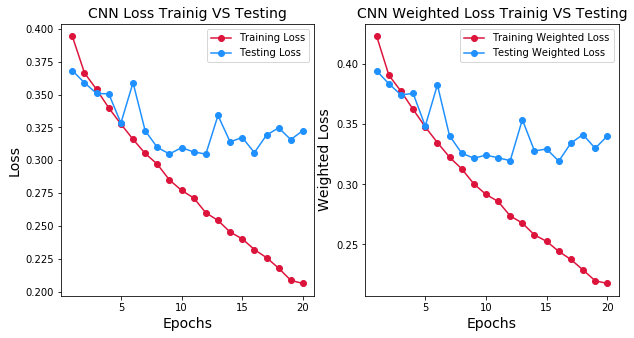

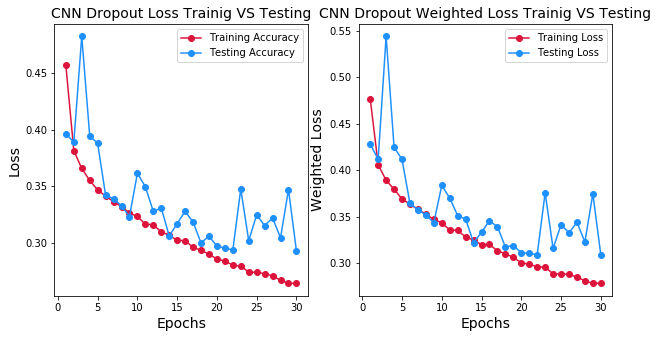

In [0]:
fig, axes = plt.subplots(1, 2, figsize = (10, 5))
axes[0].plot(range(1, len(cnn_model_process.history['loss']) + 1), cnn_model_process.history['loss'], linestyle = 'solid', marker = 'o', color = 'crimson', label = 'Training Loss')
axes[0].plot(range(1, len(cnn_model_process.history['val_loss']) + 1), cnn_model_process.history['val_loss'], linestyle = 'solid', marker = 'o', color = 'dodgerblue', label = 'Testing Loss')
axes[0].set_xlabel('Epochs', fontsize = 14)
axes[0].set_ylabel('Loss',fontsize = 14)
axes[0].set_title('CNN Loss Trainig VS Testing', fontsize = 14)
axes[0].legend(loc = 'best')
axes[1].plot(range(1, len(cnn_model_process.history['weighted_loss']) + 1), cnn_model_process.history['weighted_loss'], linestyle = 'solid', marker = 'o', color = 'crimson', label = 'Training Weighted Loss')
axes[1].plot(range(1, len(cnn_model_process.history['val_weighted_loss']) + 1), cnn_model_process.history['val_weighted_loss'], linestyle = 'solid', marker = 'o', color = 'dodgerblue', label = 'Testing Weighted Loss')
axes[1].set_xlabel('Epochs', fontsize = 14)
axes[1].set_ylabel('Weighted Loss',fontsize = 14)
axes[1].set_title('CNN Weighted Loss Trainig VS Testing', fontsize = 14)
axes[1].legend(loc = 'best')

fig, axes = plt.subplots(1, 2, figsize = (10, 5))
axes[0].plot(range(1, len(cnn_model_dropout_process.history['loss']) + 1), cnn_model_dropout_process.history['loss'], linestyle = 'solid', marker = 'o', color = 'crimson', label = 'Training Accuracy')
axes[0].plot(range(1, len(cnn_model_dropout_process.history['val_loss']) + 1), cnn_model_dropout_process.history['val_loss'], linestyle = 'solid', marker = 'o', color = 'dodgerblue', label = 'Testing Accuracy')
axes[0].set_xlabel('Epochs', fontsize = 14)
axes[0].set_ylabel('Loss',fontsize = 14)
axes[0].set_title('CNN Dropout Loss Trainig VS Testing', fontsize = 14)
axes[0].legend(loc = 'best')
axes[1].plot(range(1, len(cnn_model_dropout_process.history['weighted_loss']) + 1), cnn_model_dropout_process.history['weighted_loss'], linestyle = 'solid', marker = 'o', color = 'crimson', label = 'Training Loss')
axes[1].plot(range(1, len(cnn_model_dropout_process.history['val_weighted_loss']) + 1), cnn_model_dropout_process.history['val_weighted_loss'], linestyle = 'solid', marker = 'o', color = 'dodgerblue', label = 'Testing Loss')
axes[1].set_xlabel('Epochs', fontsize = 14)
axes[1].set_ylabel('Weighted Loss',fontsize = 14)
axes[1].set_title('CNN Dropout Weighted Loss Trainig VS Testing', fontsize = 14)
axes[1].legend(loc = 'best')

In [0]:
# class DataGenerator(keras.utils.Sequence):

#     def __init__(self, list_IDs, labels=None, batch_size=1, img_size=(512, 512, 1), 
#                  img_dir=train_images_dir, *args, **kwargs):

#         self.list_IDs = list_IDs
#         self.labels = labels
#         self.batch_size = batch_size
#         self.img_size = img_size
#         self.img_dir = img_dir
#         self.on_epoch_end()

#     def __len__(self):
#         return int(ceil(len(self.indices) / self.batch_size))
#     def __getitem__(self, index):
#         indices = self.indices[index*self.batch_size:(index+1)*self.batch_size]
#         list_IDs_temp = [self.list_IDs[k] for k in indices]
        
#         if self.labels is not None:
#             X, Y = self.__data_generation(list_IDs_temp)
#             return X, Y
#         else:
#             X = self.__data_generation(list_IDs_temp)
#             return X
#     def on_epoch_end(self):
        
        
#         if self.labels is not None: # for training phase we undersample and shuffle
#             # keep probability of any=0 and any=1
#             keep_prob = self.labels.iloc[:, 0].map({0: 0.35, 1: 0.5})
#             keep = (keep_prob > np.random.rand(len(keep_prob)))
#             self.indices = np.arange(len(self.list_IDs))[keep]
#             np.random.shuffle(self.indices)
#         else:
#             self.indices = np.arange(len(self.list_IDs))
#     def __data_generation(self, list_IDs_temp):
#         X = np.empty((self.batch_size, *self.img_size))
        
#         if self.labels is not None: # training phase
#             Y = np.empty((self.batch_size, 6), dtype=np.float32)
        
#             for i, ID in enumerate(list_IDs_temp):
#                 X[i,] = _read(self.img_dir+ID+".dcm", self.img_size)
#                 Y[i,] = self.labels.loc[ID].values
        
#             return X, Y
        
#         else: # test phase
#             for i, ID in enumerate(list_IDs_temp):
#                 X[i,] = _read(self.img_dir+ID+".dcm", self.img_size)
            
#             return X


In [0]:
# from keras import backend as K

# def weighted_log_loss(y_true, y_pred):
#     """
#     Can be used as the loss function in model.compile()
#     ---------------------------------------------------
#     """
    
#     class_weights = np.array([2., 1., 1., 1., 1., 1.])
    
#     eps = K.epsilon()
    
#     y_pred = K.clip(y_pred, eps, 1.0-eps)

#     out = -(         y_true  * K.log(      y_pred) * class_weights
#             + (1.0 - y_true) * K.log(1.0 - y_pred) * class_weights)
    
#     return K.mean(out, axis=-1)
# def _normalized_weighted_average(arr, weights=None):
#     """
#     A simple Keras implementation that mimics that of 
#     numpy.average(), specifically for this competition
#     """
    
#     if weights is not None:
#         scl = K.sum(weights)
#         weights = K.expand_dims(weights, axis=1)
#         return K.sum(K.dot(arr, weights), axis=1) / scl
#     return K.mean(arr, axis=1)

# def weighted_loss(y_true, y_pred):
#     """
#     Will be used as the metric in model.compile()
#     ---------------------------------------------
    
#     Similar to the custom loss function 'weighted_log_loss()' above
#     but with normalized weights, which should be very similar 
#     to the official competition metric:
#         https://www.kaggle.com/kambarakun/lb-probe-weights-n-of-positives-scoring
#     and hence:
#         sklearn.metrics.log_loss with sample weights
#     """
    
#     class_weights = K.variable([2., 1., 1., 1., 1., 1.])
    
#     eps = K.epsilon()
    
#     y_pred = K.clip(y_pred, eps, 1.0-eps)

#     loss = -(        y_true  * K.log(      y_pred)
#             + (1.0 - y_true) * K.log(1.0 - y_pred))
    
#     loss_samples = _normalized_weighted_average(loss, class_weights)
    
#     return K.mean(loss_samples)

# def weighted_log_loss_metric(trues, preds):
#     """
#     Will be used to calculate the log loss 
#     of the validation set in PredictionCheckpoint()
#     ------------------------------------------
#     """
#     class_weights = [2., 1., 1., 1., 1., 1.]
    
#     epsilon = 1e-7
    
#     preds = np.clip(preds, epsilon, 1-epsilon)
#     loss = trues * np.log(preds) + (1 - trues) * np.log(1 - preds)
#     loss_samples = np.average(loss, axis=1, weights=class_weights)

#     return - loss_samples.mean()